In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:

data_set = "dogs-vs-cats"

import zipfile 
with zipfile.ZipFile("/kaggle/input/"+ data_set +"/train.zip","r") as z:
    z.extractall(".")
    # save all files to kaggle/files/images
    destination = '/kaggle/files/images/train'
    z.extractall(destination)
    
with zipfile.ZipFile("/kaggle/input/"+ data_set +"/test1.zip","r") as z:
    z.extractall(".")
    # save all files to kaggle/files/images
    destination = '/kaggle/files/images/test'
    z.extractall(destination)

In [22]:
#print(os.listdir('/kaggle/files/images/test/test1'))
#print(os.listdir('/kaggle/files/images/train/train'))

In [23]:
# create a train/test df, containing the image filepaths and training label
import os
 
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

train = pd.DataFrame({'filepath': list_full_paths('/kaggle/files/images/train/train')})
train['truth_label'] = np.where(train['filepath'].str.contains('dog'), 'dog', 'cat')

test = pd.DataFrame({'filepath': list_full_paths('/kaggle/files/images/test/test1')})

In [24]:
train.head(20)

,filepath,truth_label
0,/kaggle/files/images/train/train/dog.890.jpg,dog
1,/kaggle/files/images/train/train/dog.1178.jpg,dog
2,/kaggle/files/images/train/train/dog.7845.jpg,dog
3,/kaggle/files/images/train/train/dog.4632.jpg,dog
4,/kaggle/files/images/train/train/cat.3660.jpg,cat
5,/kaggle/files/images/train/train/dog.814.jpg,dog
6,/kaggle/files/images/train/train/dog.2066.jpg,dog
7,/kaggle/files/images/train/train/dog.8575.jpg,dog
8,/kaggle/files/images/train/train/dog.1444.jpg,dog
9,/kaggle/files/images/train/train/cat.9803.jpg,cat


In [25]:
test.head()

,filepath
0,/kaggle/files/images/test/test1/10435.jpg
1,/kaggle/files/images/test/test1/6790.jpg
2,/kaggle/files/images/test/test1/4644.jpg
3,/kaggle/files/images/test/test1/1835.jpg
4,/kaggle/files/images/test/test1/1102.jpg


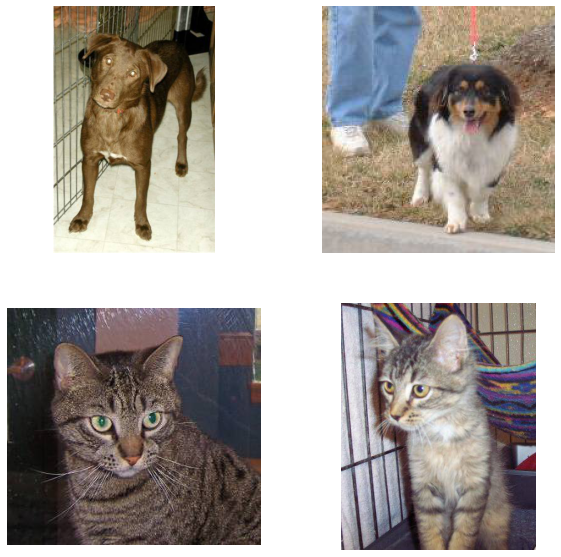

In [26]:
# examples of image visualisation
basepath = '/kaggle/files/images/train/train/'
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
_ = axs[0, 0].imshow(PIL.Image.open(basepath + 'dog.1.jpg'))
_ = axs[0, 0].axis('off')

_ = axs[0, 1].imshow(PIL.Image.open(basepath + 'dog.2.jpg'))
_ = axs[0, 1].axis('off')

_ = axs[1, 0].imshow(PIL.Image.open(basepath + 'cat.1.jpg'))
_ = axs[1, 0].axis('off')

_ = axs[1, 1].imshow(PIL.Image.open(basepath + 'cat.2.jpg'))
_ = axs[1, 1].axis('off')

In [27]:
# split train into train and validation, ensuring reproducability
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.2, random_state=1, shuffle=True)

In [28]:
#train.head(10)
#validation.head(10)
print(np.sum(train['truth_label'] == 'cat') / len(train))
print(np.sum(train['truth_label'] == 'dog') / len(train))

print(np.sum(validation['truth_label'] == 'cat') / len(validation))
print(np.sum(validation['truth_label'] == 'dog') / len(validation))

# roughly even splitting, no need for reweighting/resampling

0.5023
0.4977
0.4908
0.5092


In [29]:
# data pre-processing
train_gen = ImageDataGenerator(rescale=1. / 255)
val_gen = ImageDataGenerator(rescale=1. / 255)

train_generator      = train_gen.flow_from_dataframe(dataframe=train, x_col='filepath', y_col='truth_label', class_mode='categorical')
validation_generator = val_gen.flow_from_dataframe(dataframe=validation, x_col='filepath', y_col='truth_label', class_mode='categorical')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


# TODO data augmentation
* Random flips/rotatations
* Random zooms
* Colour scaling/reversing?

In [30]:
# data augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

input_shape = (255, 255, 3)

data_augmentation = keras.Sequential()
data_augmentation.add(RandomFlip('horizontal', input_shape=input_shape))
data_augmentation.add(RandomRotation(0.1))
data_augmentation.add(RandomZoom(0.1))

# model definition
model = Sequential()

model.add(data_augmentation)

model.add(Conv2D(input_shape=input_shape, filters=32, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(input_shape=input_shape, filters=64, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(input_shape=input_shape, filters=128, kernel_size=(4, 4), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(MaxPooling2D(2, 2))


model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_7 (Sequential)    (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 252, 252, 32)      1568      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 123, 123, 64)      32832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 128)       131200    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 29, 29, 128)      

In [ ]:
# fit data
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks
es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_lr=0.00000001)

epochs = 100
with tf.device('/device:GPU:0'):
    history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=[es, lr])

Epoch 1/100
 56/625 [=>............................] - ETA: 1:03 - loss: 0.6945 - accuracy: 0.5022

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
_ = axs[0].plot(history.history['loss'], label='Test')
_ = axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
_ = axs[0].legend()

_ = axs[1].plot(history.history['accuracy'], label='Test')
_ = axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
_ = axs[1].legend()

In [ ]:
# pred on validation, submit predictions to kaggle
#y_pred = np.argmax(model.predict(X_test), axis=1)
#from sklearn.metrics import ConfusionMatrixDisplay
#_ = ConfusionMatrixDisplay.from_predictions(test.class_protein_localization.values, y_pred, normalize='true')